# Tutorial 1 - Analyzing scRNA-seq data at the Protein Activity Level

<code style="background:lightgreen;color:black">Add description of the goal of this tutorial. Make sure that ways to load/install the package are updated. Also correct the path to the data (or include a dataset on Zenodo). Also, fix the number of the sections and fix the description according to the cell population.</code>

### Install Pyviper
Install `pyviper` from PyPI using pip. Alternatively, refer to the README in the current GitHub to install from the local directory.

In [1]:
# !pip install pyviper

### Import modules

In [2]:
import pyther
import scanpy as sc
import anndata 
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*") # for jit decorator issue with sc.pp.neighbors (09/30/2023)

### Step 1. Load a gene expression "signature" at the single-cell level 
Load gene expression signature to be used as input to the `viper` function for Protein Activity inference. Store the gene expression signature into an [AnnData](https://anndata.readthedocs.io/en/latest/) object to enable interoperability with [scanpy](https://scanpy-tutorials.readthedocs.io/en/latest/#). Display matrix dimensions with cells on rows and features (genes) on columns (after transposition). The gene expression signature was generated from a population of malignant ductal cells from publicly avaiable data from [Peng et al., 2019](https://www.nature.com/articles/s41422-019-0195-y). Please, refer to Tutorial 2 for additional details on how to generate a gene expression signature.  

In [31]:
gene_expr_url = "https://zenodo.org/records/10056139/files/Tutorial_1_gExpr_fibroblast_5802.tsv.gz"

gene_expr_signature = pd.read_csv(gene_expr_url, sep="\t") # read from remote 
gene_expr_signature = sc.AnnData(gene_expr_signature) # convert to AnnData object

gene_expr_signature

AnnData object with n_obs × n_vars = 5802 × 5000

### Step 2. Load a gene regulatory network inferred with ARACNe
Load and inspect lineage-specific gene regulatory network generated with the ARACNe3. See [ARACNe3](https://www.mdpi.com/1099-4300/25/3/542) and [ARACNe-AP](https://pubmed.ncbi.nlm.nih.gov/27153652/) for additional information on current ARACNe implementations. 

In [32]:
network_path = "https://zenodo.org/records/10056139/files/fibroblast-net.tsv" # path to ARACNe network
    
network = pd.read_csv(network_path, delimiter="\t")

Other algorithms can be used to generate gene regulatory networks, but we recommend postprocessing the output to the suitable dataframe format, with columns displayed above.

Convert the pandas DataFrame to an object of class `Interactome` to enable easier manipulation and show the number of regulons using the `size()` method. Type `help(pyther.Interactome)` to see all available methods.

In [5]:
network_interactome = pyther.Interactome('fibroblasts', network) # convert to class Interactome
network_interactome.size() # show number of regulons in the Interactome

6437

Display the first 5 interactions in the regulatory network. `mor` and `likelihood` represent the mode of regulation of the given regulator-target pair and the likelihood of the interaction, respectively.

In [6]:
network_interactome.net_table.head()

,regulator,target,mor,likelihood
0,AATF,CCM2,0.012159,0.999799
1,AATF,THOC2,0.007487,0.999597
2,AATF,RAP1A,-0.021062,0.999396
3,AATF,SFT2D1,0.019400,0.999195
4,AATF,DNAJC2,0.047129,0.998993


Filter out targets in the `Interactome` that are not present in the gene expression matrix. This step is recommended before running `viper`. 

In [7]:
network_interactome.filter_targets(gene_expr_signature.var_names)

As an example, display the number of targets of a couple of regulators, MYC and SERPINA12.

In [8]:
n_MYC = len(network_interactome.get_reg('MYC')) # number of MYC targets in the network
n_EGFR = len(network_interactome.get_reg('EGFR')) # number of SERPINA12 targets in the network

print("The number of targets of MYC and SERPINA12 are " + str(n_MYC) + " and " + str(n_EGFR) + ", respectively.")

The number of targets of MYC and SERPINA12 are 284 and 183, respectively.


### Step 3. Convert the gene expression signature into a protein activity matrix using viper
`viper` transforms a gene expression signature into a protein activity matrix by performing enrichment analysis on regulons. Two methods for enrichment analysis are allowed: [aREA](https://www.nature.com/articles/ng.3593) (default) and [NaRnEA](https://www.mdpi.com/1099-4300/25/3/542) (by setting `enrichment="narnea"`).

#### Method 1 - protein activity inference using aREA
As we have seen (section above), different regulators can potentially have different number of targets. We prune each regulon to have the same number of targets (50 in this case). This step is advisable to avoid regulators with an exceedingly number of targets to dominate those with fewer when computing the NES, thus making NES scores comparable.

In [9]:
network_pruned = network_interactome.copy() # generate a copy of the unpruned network before pruning it
network_pruned.prune(max_targets=50,eliminate=True) # prune interactome to have exactly 50 targets

Now all the regulators in the network have exactly 50 transcriptional targets.

In [10]:
n_MYC = len(network_pruned.get_reg('MYC')) # number of MYC targets in the network
EGFR = len(network_pruned.get_reg('EGFR')) # number of SERPINA12 targets in the network

print("Number of MYC targets: " + str(n_MYC) + "\nNumber of EGFR targets: " + str(EGFR))

Number of MYC targets: 50
Number of EGFR targets: 50


<div class="alert alert-block alert-success">
<b></b> Run `viper` to compute the protein activity matrix (aREA method).
</div>
 
The mandatory inputs to `viper` are a gene expression signature and a gene regulatory network. We will set the output output to be an ndarray (The default output would be an AnnData object).

In [11]:
ProtAct_aREA = pyther.viper(gex_data=gene_expr_signature, # gene expression signature
                             interactome=network_pruned, # gene regulatory network
                             enrichment = "area",
                             output_as_anndata=False,
                             njobs=1,
                             verbose=False)

`ProtAct_aREA` contains the activity of each regulatory protein computed as a Normalized Enrichment Score (NES) for each single cell.

In [12]:
ProtAct_aREA # display the protein activity matrix 

regulator,AAMP,AATF,ABCA1,ABCA12,ABCA3,ABCA7,ABCA8,ABCB1,ABCB4,ABCB5,...,ZSWIM5,ZSWIM6,ZSWIM7,ZWINT,ZXDA,ZXDB,ZXDC,ZYX,ZZEF1,ZZZ3
T1_AAACCTGAGATGTCGG,-0.014206,0.027712,0.057313,0.095473,-0.021236,0.038511,-0.598815,-1.505867,0.044179,-0.032513,...,0.157645,0.190605,-1.006026,-0.016635,0.053824,-0.483114,-0.164187,0.598380,-0.219886,0.042218
T1_AACTGGTTCTAACGGT,-0.251498,0.049527,0.058710,0.086291,-0.130560,0.008993,-0.170331,-0.038688,-0.033160,-0.023936,...,0.050540,-0.001874,0.852565,-0.003012,0.046448,-0.073733,0.650326,1.442805,0.026046,-0.014535
T1_AAGGTTCGTGTCAATC,-0.436400,0.058650,0.071995,0.085530,0.007212,-0.037141,-0.350010,-0.271247,0.026917,-0.005419,...,0.588326,-0.040662,0.265022,-0.185548,-0.007104,-0.078222,0.020503,-0.784129,-0.116486,0.008290
T1_ACAGCCGTCAAGCCTA,-1.034668,0.052937,0.096666,0.110275,-0.019219,-0.021259,-0.021779,-0.703762,0.007190,-0.045264,...,0.167126,0.056834,0.557881,-0.548752,-0.010246,-0.044021,-0.007267,0.501714,-0.001597,-0.007290
T1_AGACGTTAGGCGACAT,-0.811760,0.043792,0.066080,0.069523,-0.035705,-0.035428,-0.317873,0.037946,-0.005969,-0.024018,...,0.104896,-0.012483,-0.457026,0.211869,-0.144309,-0.019348,-0.035585,0.085054,-0.352943,-0.011871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T24_TTGCGTCCAGACAAAT,0.002299,0.013470,0.060106,1.236346,0.018945,0.028562,-0.093820,-1.275721,-1.226240,0.386276,...,-0.031268,-0.062835,-0.006546,0.019039,0.068665,-0.544908,0.573362,-0.551146,-0.000499,-0.129102
T24_TTGCGTCCATTAACCG,-0.129001,0.034863,0.089672,0.044609,0.040947,-0.078091,-0.200762,-0.007241,0.042752,-0.070949,...,0.024643,-0.484168,-0.022466,-0.023258,-0.045327,-0.041769,-0.025815,-0.003803,-0.054201,-0.011256
T24_TTTATGCTCCTTTACA,-0.354839,0.036691,0.062033,0.054651,-0.018591,0.102881,-0.535426,-0.809012,0.000806,0.072612,...,0.074007,0.091054,0.080505,0.003998,0.030402,-0.000688,-0.049335,-1.073907,-0.215079,0.007779
T24_TTTCCTCCACCGGAAA,-0.742043,0.049942,0.065039,0.105232,0.236517,-0.762427,-0.290367,1.586747,0.020128,-0.075647,...,0.032234,0.398886,-0.547757,-0.016941,0.260247,-0.038721,0.012140,0.437124,-0.040129,-0.040400


#### Method 2 - protein activity inference using (matrix)-NaRnEA

<div class="alert alert-block alert-success">
<b></b> Run `viper` to compute the protein activity matrix (matrix-NaRnEA method).
</div>
 

Compute the protein activity using `viper` with NaRnEA as the enrichment method. Unlike aREA, NaRnEA can run with regulons of different sizes, i.e. different number of targets per regulator. Store the output in an `AnnData` object (default).

In [13]:
ProtAct_NaRnEA = pyther.viper(gex_data=gene_expr_signature, # gene expression signature
                                 interactome=network_interactome, # gene regulatory network
                                 enrichment = "narnea",
                                 njobs=1,
                                 verbose=False)

Show the output type and length of `ProtAct_NaRnEA`.

In [14]:
ProtAct_NaRnEA # display the protein activity matrix as AnnData object 

AnnData object with n_obs × n_vars = 5802 × 6413
    uns: 'gex_data'
    layers: 'pes'

When using NaRnEA, `viper` returns an additional layer, `pes` that stores the Proportional Enrichment Scores (PES) for regulator, a measure bound in the interval $-1 \le PES \le 1$ that can be used as a measure of effect size. For further details, see [Griffin et al., 2022](https://pubmed.ncbi.nlm.nih.gov/36981431/).

Display NES protein activity matrix.


In [15]:
ProtAct_NaRnEA.to_df() # NES matrix

,AAMP,AATF,ABCA1,ABCA12,ABCA3,ABCA7,ABCA8,ABCB1,ABCB4,ABCB5,...,ZSWIM5,ZSWIM6,ZSWIM7,ZWINT,ZXDA,ZXDB,ZXDC,ZYX,ZZEF1,ZZZ3
T1_AAACCTGAGATGTCGG,4.715789,-6.613786,7.001248,1.851045,1.843629,-0.857902,14.543342,-0.613878,-0.824745,0.406057,...,-1.862346,3.146378,-7.006648,-0.756162,-2.003027,1.459875,2.712799,5.787629,2.397046,-2.582086
T1_AACTGGTTCTAACGGT,-7.191714,7.533881,9.429433,4.088336,-0.461214,1.055557,-18.886093,1.401654,-0.798170,1.079553,...,2.199012,-3.213969,-7.219745,0.821136,1.227563,-1.558459,-1.394093,12.747848,1.822417,2.953031
T1_AAGGTTCGTGTCAATC,8.887137,-9.449057,-10.272199,3.190093,-1.265178,0.657827,20.582304,0.466253,-0.916708,0.486921,...,1.655850,3.406829,-8.988820,-1.780032,-0.947679,-2.583600,1.037094,-11.109167,-1.955563,-2.474079
T1_ACAGCCGTCAAGCCTA,7.847414,6.900573,9.575873,-2.852121,-0.872999,-1.455654,23.062950,-0.603498,1.127638,0.936162,...,-1.165667,-2.528141,-6.812299,-1.115750,-1.571316,1.245981,2.074361,-11.699137,2.160041,2.499193
T1_AGACGTTAGGCGACAT,7.643162,6.953849,-8.838992,2.588946,0.552425,-0.694893,-15.233547,0.163285,2.939726,-0.930142,...,1.883423,-2.452126,-9.295234,0.852636,1.995564,-1.274287,-2.888875,8.253686,-2.171622,3.023637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T24_TTGCGTCCAGACAAAT,3.929488,3.904004,-7.629382,-2.257839,0.547175,-1.310761,10.857200,0.809013,-1.093720,1.711279,...,-2.431247,2.670952,5.755338,0.977276,-2.342592,-0.952300,1.586434,6.731536,2.967126,1.218217
T24_TTGCGTCCATTAACCG,-7.197257,7.793606,8.194140,-2.333065,-1.661859,1.403331,-19.088629,0.623605,-0.571697,-1.285721,...,1.153792,-2.933194,7.263271,-0.940619,-1.737071,1.691340,-1.825287,10.659641,1.579409,2.971451
T24_TTTATGCTCCTTTACA,-7.103387,8.042507,-8.372260,2.609825,0.896921,-2.094449,20.645484,-0.346492,0.872927,-0.579501,...,1.109876,2.796211,6.435829,1.046557,1.433361,-1.580545,1.450763,-10.226545,1.772312,2.924802
T24_TTTCCTCCACCGGAAA,-6.267298,-5.975001,-6.912350,-3.515971,0.877991,-1.020563,-11.196501,0.534728,-1.318767,0.807623,...,1.258743,-3.328210,5.359631,-2.210881,-1.586171,-1.064334,0.944330,-6.458201,-1.191704,2.884055


Display the PES protein activity matrix.

In [16]:
ProtAct_NaRnEA.to_df(layer="pes") # PES matrix

,AAMP,AATF,ABCA1,ABCA12,ABCA3,ABCA7,ABCA8,ABCB1,ABCB4,ABCB5,...,ZSWIM5,ZSWIM6,ZSWIM7,ZWINT,ZXDA,ZXDB,ZXDC,ZYX,ZZEF1,ZZZ3
T1_AAACCTGAGATGTCGG,0.240772,-0.304270,0.281038,0.074875,0.065383,-0.030210,0.378750,-0.021176,-0.028191,0.012894,...,-0.057990,0.109255,-0.352088,-0.026435,-0.069684,0.050032,0.092210,0.262122,0.085055,-0.092093
T1_AACTGGTTCTAACGGT,-0.377572,0.314127,0.353572,0.160783,-0.015217,0.035737,-0.497909,0.047375,-0.026517,0.033253,...,0.065166,-0.115518,-0.365130,0.029192,0.042427,-0.052575,-0.044594,0.546236,0.062533,0.098134
T1_AAGGTTCGTGTCAATC,0.411746,-0.426309,-0.463015,0.121526,-0.039884,0.021507,0.489378,0.015299,-0.029489,0.014491,...,0.047115,0.107279,-0.455701,-0.057125,-0.030605,-0.084660,0.033765,-0.547947,-0.066875,-0.085122
T1_ACAGCCGTCAAGCCTA,0.373952,0.280809,0.347536,-0.110712,-0.028223,-0.049295,0.563023,-0.019842,0.036926,0.028396,...,-0.035112,-0.090271,-0.344878,-0.036706,-0.051855,0.040700,0.068411,-0.576989,0.072889,0.081400
T1_AGACGTTAGGCGACAT,0.367726,0.285936,-0.395159,0.100920,0.019161,-0.023652,-0.399057,0.005474,0.096805,-0.028409,...,0.055218,-0.087717,-0.469730,0.030140,0.068457,-0.042642,-0.091376,0.348384,-0.075733,0.099308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T24_TTGCGTCCAGACAAAT,0.204446,0.174607,-0.337181,-0.093020,0.019611,-0.046764,0.288005,0.028439,-0.037907,0.055128,...,-0.076656,0.094553,0.273277,0.035624,-0.082810,-0.033380,0.054557,0.311536,0.106925,0.042919
T24_TTGCGTCCATTAACCG,-0.379965,0.335563,0.321241,-0.093680,-0.056283,0.048429,-0.508088,0.021407,-0.019326,-0.040297,...,0.034984,-0.105993,0.329845,-0.032393,-0.059631,0.057257,-0.059820,0.473351,0.055332,0.101333
T24_TTTATGCTCCTTTACA,-0.374228,0.343792,-0.370403,0.103941,0.031494,-0.072713,0.525797,-0.011750,0.029375,-0.018084,...,0.033471,0.094812,0.289742,0.037420,0.050027,-0.053926,0.048746,-0.502225,0.061779,0.099145
T24_TTTCCTCCACCGGAAA,-0.332941,-0.275806,-0.310930,-0.140664,0.031023,-0.035522,-0.299154,0.018338,-0.044461,0.025257,...,0.037913,-0.120996,0.238777,-0.075475,-0.054143,-0.036417,0.031897,-0.320772,-0.042458,0.097503


Notice that when setting the `viper` output to be an object of class `AnnData`, the input gene expression `AnnData` is stored under the attribute `gex_data`:

In [17]:
ProtAct_NaRnEA.uns["gex_data"][0:5,0:5].to_df()

,RP11-54O7.3,SAMD11,PLEKHN1,RP11-54O7.17,HES4
T1_AAACCTGAGATGTCGG,-0.145409,-0.513375,-0.130302,-0.134275,1.855504
T1_AACTGGTTCTAACGGT,-0.108846,-0.390002,-0.096722,-0.101255,2.064095
T1_AAGGTTCGTGTCAATC,-0.084144,-0.306366,-0.074026,-0.078937,1.387576
T1_ACAGCCGTCAAGCCTA,-0.099796,-0.359357,-0.088408,-0.093080,-0.622520
T1_AGACGTTAGGCGACAT,-0.099830,-0.359472,-0.088440,-0.093111,3.986061


### Step 4. Analyze single-cells at the Protein Activity level 
We present some potential analyses and postprocessing that can be done using the protein activity matrix. 

Set the set of regulators as those for human. This is step is redundant in this case, because the default species in PyVIPER is `"human"`, but we show it to demonstrate how to have full control on the analysis.  

In [18]:
pyther.config.set_regulators_species_to_use(species="human")

Run PCA to reduce the dimensionality of the dataset, using by projecting the PES of transcriptional regulators (TFs) and co-transcriptional regulators (coTFs) by setting `filter_by_feature_groups=["tfs", "cotfs"]`. In this example, we focus on TFs and coTFs because we are interested in proteins involved in transcriptional regulation and that are mechanistic determinants of cell state, as shown in [Paull et al., 2021](https://www.sciencedirect.com/science/article/pii/S0092867420316172?via%3Dihub) and [Califano & Alvarez, 2016](https://www.nature.com/articles/nrc.2016.124). Possible options for this parameter are `["tfs", "cotfs", "sig", "surface"]`, where the latter refer to signaling proteins and surface markers, respectively, and `None` to use all features.

In [19]:
pyther.tl.pca(ProtAct_NaRnEA, layer="pes", filter_by_feature_groups=["tfs","cotfs"], zero_center=True,  svd_solver='arpack')

(5802, 2164)


The `tl` module provides wrappers to several `scanpy.tl` functions to simplify the postprocessing of protein activity data. For instance, in the cell above we can easily subset the class of regulatory proteins to analyze. 

Compute the neighbors graph of cells using the PCA representation of the protein activity matrix. For sake of simplicity, we set 10 nearest neightbors and 50 principal components. Typically, these parameters need tuning.

In [20]:
sc.pp.neighbors(ProtAct_NaRnEA, metric="correlation", n_neighbors=20, n_pcs=50)

Cluster at protein activity using the Leiden algorithm with `resolution=0.2` (in real applications this parameter should be optimized).

In [21]:
sc.tl.leiden(ProtAct_NaRnEA, resolution=0.1, n_iterations=-1)

Generate a [UMAP](https://arxiv.org/abs/1802.03426) embedding of the previously computed graph. 

In [22]:
sc.tl.umap(ProtAct_NaRnEA)

Display the 2-dimensional UMAP embedding with the corresponding function from the `pyther.pl`, a module that provides wrappers for `scanpy.pl` functions for enhanced visualization of key protein activity features. Color by cluster.  

/Users/lucazanella7/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/lucazanella7/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/lucazanella7/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


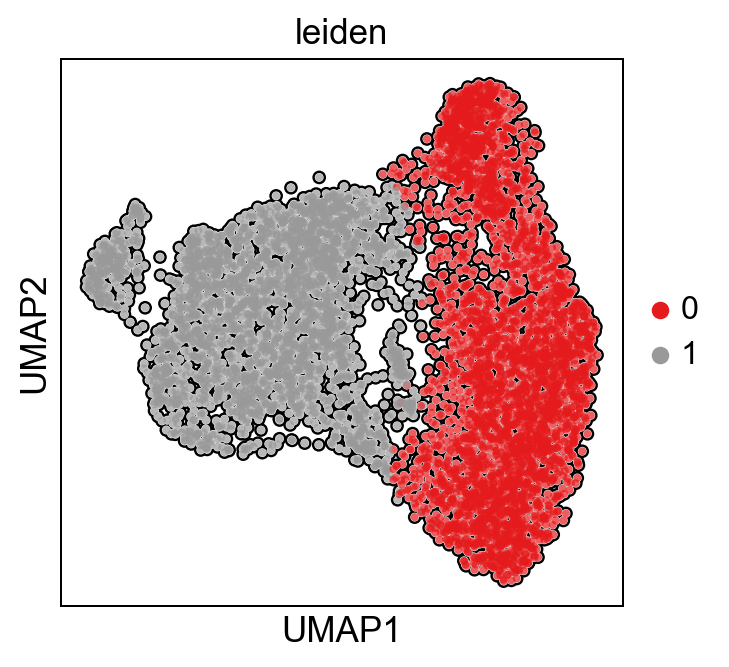

In [23]:
sc.set_figure_params(dpi=90)
n_cells = ProtAct_NaRnEA.shape[0]
dot_size = 120000 / n_cells*2
pyther.pl.umap(ProtAct_NaRnEA, color='leiden', palette="Set1", size=dot_size,add_outline=True)

Find the most active regulators in each cluster by integrating the NES of each regulatory protein across all cells in a cluster using the Stouffer's method: $$ NES^C_j = \frac{\sum_{k \in C}NES_{k,j}}{\sqrt{n^C}} $$ where $NES^C_j$ denotes the integrated NES for regulator $j$ in cluster/cell type $C$, $NES_{k,j}$ is the NES of regulator $j$ in cluster/cell type $C$ and $n^C$ is the number of cells in cluster $C$.

In [24]:
ProtAct_NaRnEA = pyther.tl.stouffer(ProtAct_NaRnEA, "leiden", filter_by_feature_groups=["tfs","cotfs"]) # Stouffer integration 

/Users/lucazanella7/Desktop/ColumbiaProjects/pyther/pyther/tl.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['stouffer'] = result_df


Display the integrated NES scores in each cluster, that are stored in `.uns` under`stouffer`.

In [25]:
NES_integrated = ProtAct_NaRnEA.uns["stouffer"] 
NES_integrated

,AATF,ABCG1,ABCG4,ABLIM3,ABT1,ACAD8,ACTN2,ACTR5,ADH1A,ADNP,...,ZSWIM1,ZSWIM3,ZSWIM4,ZSWIM5,ZSWIM6,ZSWIM7,ZXDA,ZXDB,ZXDC,ZZEF1
0,138.758551,157.017538,8.435103,-30.641790,26.574730,-10.946720,-21.213056,-40.604782,9.065425,-107.405369,...,1.148882,-34.566939,51.018607,15.460432,-97.134274,2.11663,-7.831696,-13.075635,-10.744022,-42.371947
1,-70.852424,-139.222407,-22.012080,-20.889821,32.830841,38.477351,-2.410587,-34.569782,12.323403,-161.775796,...,32.750964,24.827629,-32.286916,11.768385,-52.230711,79.01672,26.360216,-13.952766,28.025574,21.004673


Analogously, `stouffer_clusters_df` can be used to performed the same operations in Pandas DataFrames. Remove ribosomal proteins from the Stouffer-integrated matrix (ribosomal protein genes are among the most highly expressed genes in most cell types).

In [26]:
filtered_proteins = NES_integrated.columns[~NES_integrated.columns.str.startswith('RP')].to_list() # Exclude columns starting with 'RP' from integrated matrix
NES_integrated = NES_integrated.loc[:,filtered_proteins] # remove ribosomal proteins from DataFrame

Extract the 10 most activated regulatory protein in each cluster

In [27]:
active_proteins = NES_integrated.apply(lambda row: row.nlargest(10).index.tolist(), axis=1)  # the top 10 most activated proteins in each cell type
active_proteins

0    [LOXL2, MMP14, INHBA, PFN1, WNT5A, LEF1, ID3, ...
1    [TSHZ2, NFIA, NFIB, ZBTB16, TCF21, IGF1, TSC22...
dtype: object

Show the NES of the top activated proteins from `ProtAct_NaRnEA` on a heatmap

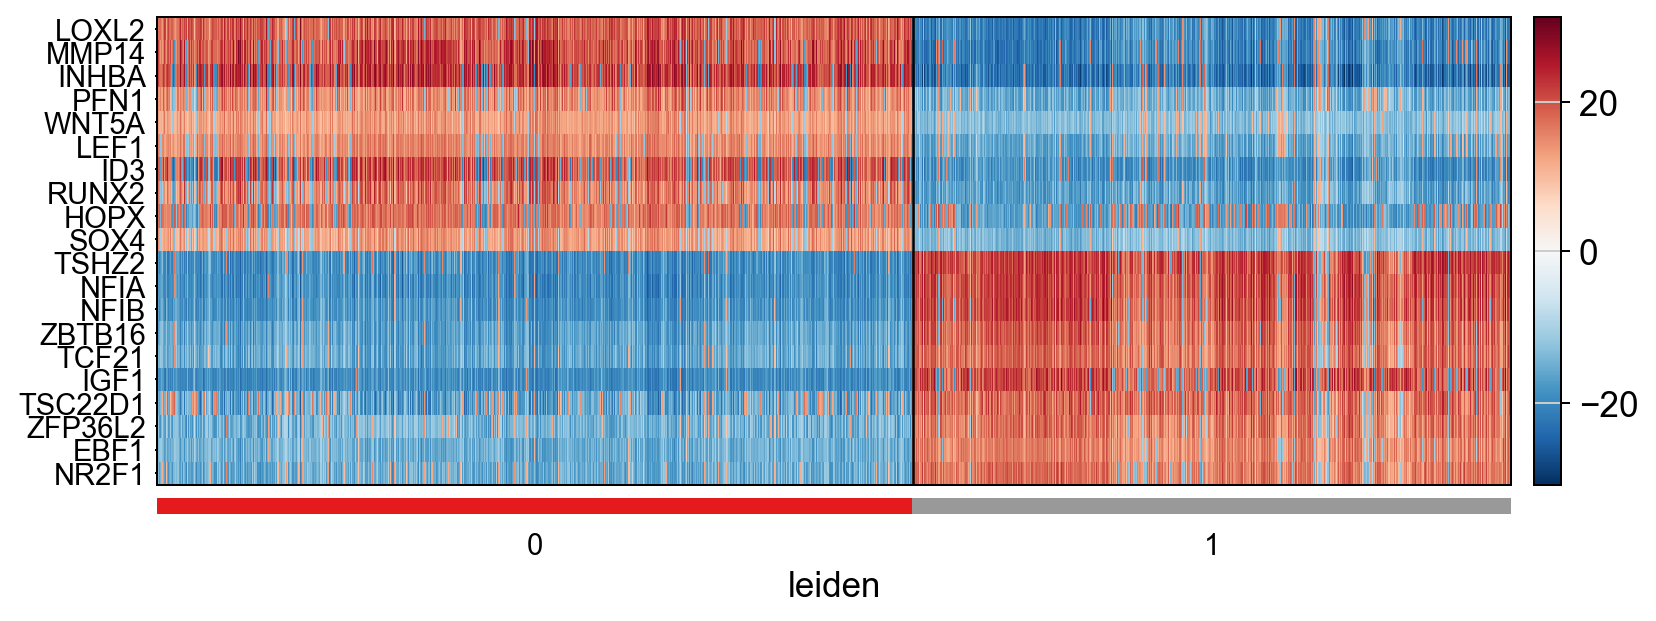

In [28]:
protein_set = active_proteins.sum() # protein set to display on the heatmap
ax = pyther.pl.heatmap(ProtAct_NaRnEA, var_names=protein_set, groupby="leiden", vcenter=0, cmap="RdBu_r",dendrogram=False,swap_axes=True, show_gene_labels=True)

### Part with literature markers
<code style="background:lightgreen">Part with literature markers (also fix title). I think to remove this part </code>

In [ ]:
markers_fibroblasts = {
    'iCAF': ['C3', 'C4B', 'GSN', 'TNXB'],
    'myCAF': ['ARHGDIB', 'CAV1', 'CD74', 'CLU', 'CXADR', 'EZR', 'HSPB1', 'NKAIN4', 'SLC9A3R1'],
    'apCAF': ['CXCL14', 'SDC1', 'TGFB1', 'THY1']
}

iCAFs_df = pd.DataFrame(columns=["regulator","target","mor","likelihood"])

# iCAFs interactome
iCAFs_df["target"] = markers_fibroblasts["iCAF"]
iCAFs_df["regulator"] = "iCAF"; iCAFs_df["mor"] = 1; iCAFs_df["likelihood"] = 1

# myCAFs interactome
myCAFs_df = pd.DataFrame(columns=["regulator","target","mor","likelihood"])
myCAFs_df["target"] = markers_fibroblasts["myCAF"]
myCAFs_df["regulator"] = "myCAF"; myCAFs_df["mor"] = 1; myCAFs_df["likelihood"] = 1

# apCAFs interactome
apCAFs_df = pd.DataFrame(columns=["regulator","target","mor","likelihood"])
apCAFs_df["target"] = markers_fibroblasts["apCAF"]
apCAFs_df["regulator"] = "apCAF"; apCAFs_df["mor"] = 1; apCAFs_df["likelihood"] = 1

CAFs_markers = pd.concat([iCAFs_df, myCAFs_df, apCAFs_df], ignore_index=True)

CAFs_interactome = pyther.Interactome("CAFs_markers", CAFs_markers)



In [ ]:
markers_enrichment = pyther.viper(ProtAct_NaRnEA, interactome=CAFs_interactome, enrichment="narnea",output_as_anndata=False, min_targets=1)

markers_enrichment = pyther.tl.nes_to_pval_df(markers_enrichment["nes"])

markers_enrichment_pval = pyther.tl.nes_to_pval_df(markers_enrichment["nes"])

np.sum(markers_enrichment_pval < 0.05)

### Key Takeaways
<code style="background:lightgreen">Add recap and key takeaways</code>